In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
df_merged = pd.read_csv('df_merged.csv')

### 생장 주기에 대한 이론과 데이터 검증

In [3]:
# 월별 주요 지표 계산
monthly_stats = df_merged.groupby('month').agg({
    'PI_abs': ['mean', 'std'],
    'Fv-Fm': ['mean', 'std'],
    'TChl': ['mean', 'std'],
    'Leaf_TPC': 'mean',
    'Root_TPC': 'mean'
}).round(3)

In [4]:
# Source-Sink 비율 계산
monthly_stats['Source_Sink_Ratio'] = (monthly_stats['Leaf_TPC']['mean'] / 
                                       monthly_stats['Root_TPC']['mean']).round(2)

In [5]:
print(monthly_stats)

      PI_abs         Fv-Fm           TChl        Leaf_TPC Root_TPC  \
        mean    std   mean    std    mean    std     mean     mean   
month                                                                
5      2.510  0.771  0.836  0.006  10.756  2.378    7.405    6.354   
6      2.196  1.025  0.824  0.012   6.749  1.440    8.124    5.189   
7      1.864  0.484  0.821  0.008   6.789  1.597    7.951    5.252   
8      1.458  0.442  0.808  0.006   7.113  1.892    7.682    4.639   
9      0.401  0.286  0.713  0.053   5.739  2.160    7.186    4.903   

      Source_Sink_Ratio  
                         
month                    
5                  1.17  
6                  1.57  
7                  1.51  
8                  1.66  
9                  1.47  


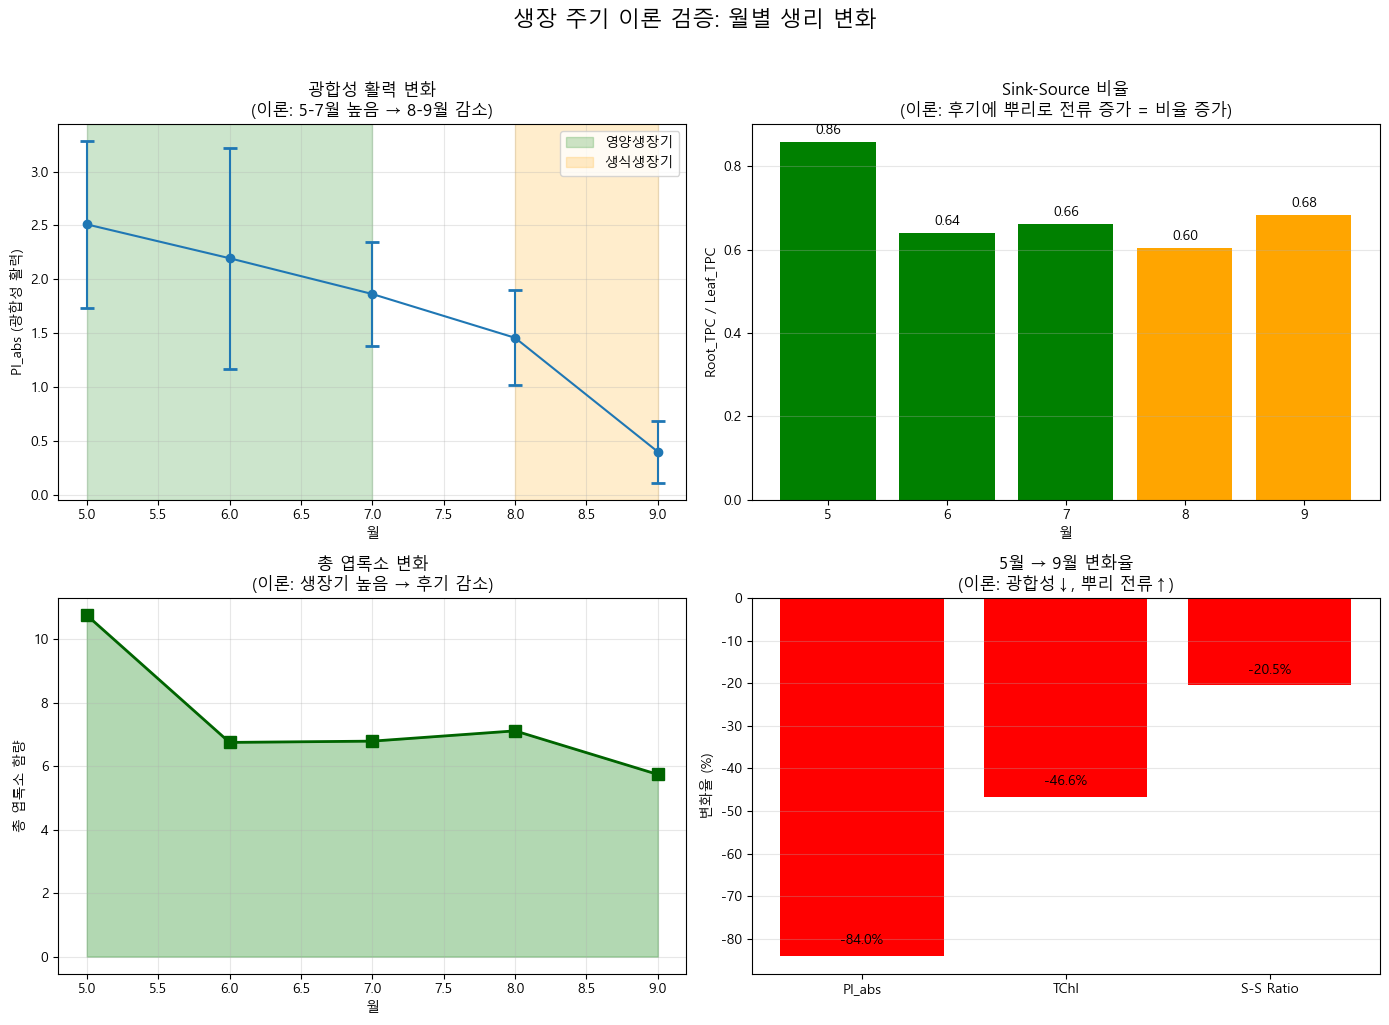

In [10]:
# 수정된 시각화: 생장 주기별 변화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('생장 주기 이론 검증: 월별 생리 변화', fontsize=16, y=1.02)

# 안전한 데이터 추출 함수
def safe_extract_data(monthly_stats, months, column_tuple, default_value=0):
    """MultiIndex DataFrame에서 안전하게 데이터 추출"""
    try:
        if isinstance(column_tuple, tuple):
            return [monthly_stats.loc[m, column_tuple] if not pd.isna(monthly_stats.loc[m, column_tuple]) 
                   else default_value for m in months]
        else:
            return [monthly_stats.loc[m, column_tuple] if not pd.isna(monthly_stats.loc[m, column_tuple]) 
                   else default_value for m in months]
    except KeyError as e:
        print(f"컬럼 {column_tuple}에 접근할 수 없습니다: {e}")
        return [default_value] * len(months)

# 월 목록 생성
months = sorted(df_merged['month'].unique())

# 1. PI_abs 변화 (수정됨)
ax1 = axes[0, 0]
try:
    pi_means = safe_extract_data(monthly_stats, months, ('PI_abs', 'mean'))
    pi_stds = safe_extract_data(monthly_stats, months, ('PI_abs', 'std'))
    
    ax1.errorbar(months, pi_means, yerr=pi_stds, marker='o', capsize=5, capthick=2) #errorbar 선 그래프프
    ax1.set_xlabel('월')
    ax1.set_ylabel('PI_abs (광합성 활력)')
    ax1.set_title('광합성 활력 변화\n(이론: 5-7월 높음 → 8-9월 감소)')
    ax1.grid(True, alpha=0.3)
    ax1.axvspan(5, 7, alpha=0.2, color='green', label='영양생장기')
    ax1.axvspan(8, 9, alpha=0.2, color='orange', label='생식생장기')
    ax1.legend()
except Exception as e:
    print(f"PI_abs 그래프 오류: {e}")

# 2. Source-Sink 비율 (수정됨) - 올바른 공식
ax2 = axes[0, 1]
try:
    ss_ratio = []
    for m in months:
        leaf_val = monthly_stats.loc[m, ('Leaf_TPC', 'mean')] if ('Leaf_TPC', 'mean') in monthly_stats.columns else monthly_stats.loc[m, 'Leaf_TPC']
        root_val = monthly_stats.loc[m, ('Root_TPC', 'mean')] if ('Root_TPC', 'mean') in monthly_stats.columns else monthly_stats.loc[m, 'Root_TPC']
        
        # 수정된 계산 - 방법 1: Root/Leaf 비율
        ss_ratio.append(float(root_val) / float(leaf_val))
        
        # 또는 방법 2: 뿌리 비중
        # ss_ratio.append(float(root_val) / (float(leaf_val) + float(root_val)))
    
    bars = ax2.bar(months, ss_ratio, color=['green' if m <= 7 else 'orange' for m in months])
    ax2.set_xlabel('월')
    ax2.set_ylabel('Root_TPC / Leaf_TPC')  # 수정된 라벨
    ax2.set_title('Sink-Source 비율\n(이론: 후기에 뿌리로 전류 증가 = 비율 증가)')  # 수정된 제목
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(ss_ratio):
        ax2.text(months[i], v + 0.02, f'{v:.2f}', ha='center')
        
except Exception as e:
    print(f"Source-Sink 비율 그래프 오류: {e}")

# 3. 엽록소 함량 변화 (수정됨)
ax3 = axes[1, 0]
try:
    tchl_means = safe_extract_data(monthly_stats, months, ('TChl', 'mean'))
    
    ax3.plot(months, tchl_means, marker='s', markersize=8, linewidth=2, color='darkgreen')
    ax3.set_xlabel('월')
    ax3.set_ylabel('총 엽록소 함량')
    ax3.set_title('총 엽록소 변화\n(이론: 생장기 높음 → 후기 감소)')
    ax3.grid(True, alpha=0.3)
    ax3.fill_between(months, tchl_means, alpha=0.3, color='green')
    
except Exception as e:
    print(f"엽록소 그래프 오류: {e}")

# 4. 변화율 요약 (수정됨)
ax4 = axes[1, 1]
try:
    if 5 in months and 9 in months:
        may_idx = months.index(5)
        sep_idx = months.index(9)
        
        # 안전한 변화율 계산
        pi_change = ((pi_means[sep_idx] - pi_means[may_idx]) / pi_means[may_idx] * 100) if pi_means[may_idx] != 0 else 0 # (9월값 - 5월값) / 5월값 x 100
        tchl_change = ((tchl_means[sep_idx] - tchl_means[may_idx]) / tchl_means[may_idx] * 100) if tchl_means[may_idx] != 0 else 0
        ss_change = ((ss_ratio[sep_idx] - ss_ratio[may_idx]) / ss_ratio[may_idx] * 100) if ss_ratio[may_idx] != 0 else 0
        
        changes = {
            'PI_abs': pi_change,
            'TChl': tchl_change,
            'S-S Ratio': ss_change
        }
        
        colors = ['red' if v < 0 else 'blue' for v in changes.values()]
        bars = ax4.bar(changes.keys(), changes.values(), color=colors)
        ax4.set_ylabel('변화율 (%)')
        ax4.set_title('5월 → 9월 변화율\n(이론: 광합성↓, 뿌리 전류↑)')
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax4.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars, changes.values()):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{value:.1f}%', ha='center', va='bottom')
                    
except Exception as e:
    print(f"변화율 그래프 오류: {e}")

plt.tight_layout()
plt.show()

- Source-Sink 비율에서 뿌리로 전류 증가 시 뿌리 저장 효율이 늘어나는 것인데 별 차이 없어 보임.
- -> 온도, 습도, 토양 조건 등 다양한 방법으로 EDA 해서 확인해봐야 명확히 보일듯.
- 총 엽록소 변화 감소 = 광합성 감소를 보여줌
- -> PI_abs 급감 = 천궁 자연적 생리현상으로 취급해야함.
- 뿌리 전류 많이 증가 한 거로 보임.

### 시나리오별 스트레스 반응 메커니즘 확인
- CO2 농도 증가 따른 광합성 시스템 반응 확인

In [11]:
# 시나리오별 통계
scenario_stats = df_merged.groupby('scenario').agg({
    'CO2ppm': 'mean',
    'Temp': 'mean',
    'Fv-Fm': 'mean',
    'PI_abs': 'mean',
    'TChl': 'mean',
    'Dio-RC': 'mean',
    'ABS-RC': 'mean',
    'Leaf_TPC': 'mean',
    'Root_TPC': 'mean'
}).round(3)

In [13]:
# 열소산 비율 계산
scenario_stats['Dissipation_Ratio'] = (scenario_stats['Dio-RC'] / 
                                        scenario_stats['ABS-RC'] * 100).round(1)

print(scenario_stats)

            CO2ppm    Temp  Fv-Fm  PI_abs   TChl  Dio-RC  ABS-RC  Leaf_TPC  \
scenario                                                                     
SSP1       427.826  22.859  0.815   2.198  8.832   0.355   1.854     7.482   
SSP3       918.367  24.657  0.790   1.413  6.772   0.495   2.227     7.801   
SSP5      1173.970  25.465  0.789   1.228  5.628   0.528   2.377     7.842   

          Root_TPC  Dissipation_Ratio  
scenario                               
SSP1         5.114               19.1  
SSP3         5.154               22.2  
SSP5         5.174               22.2  


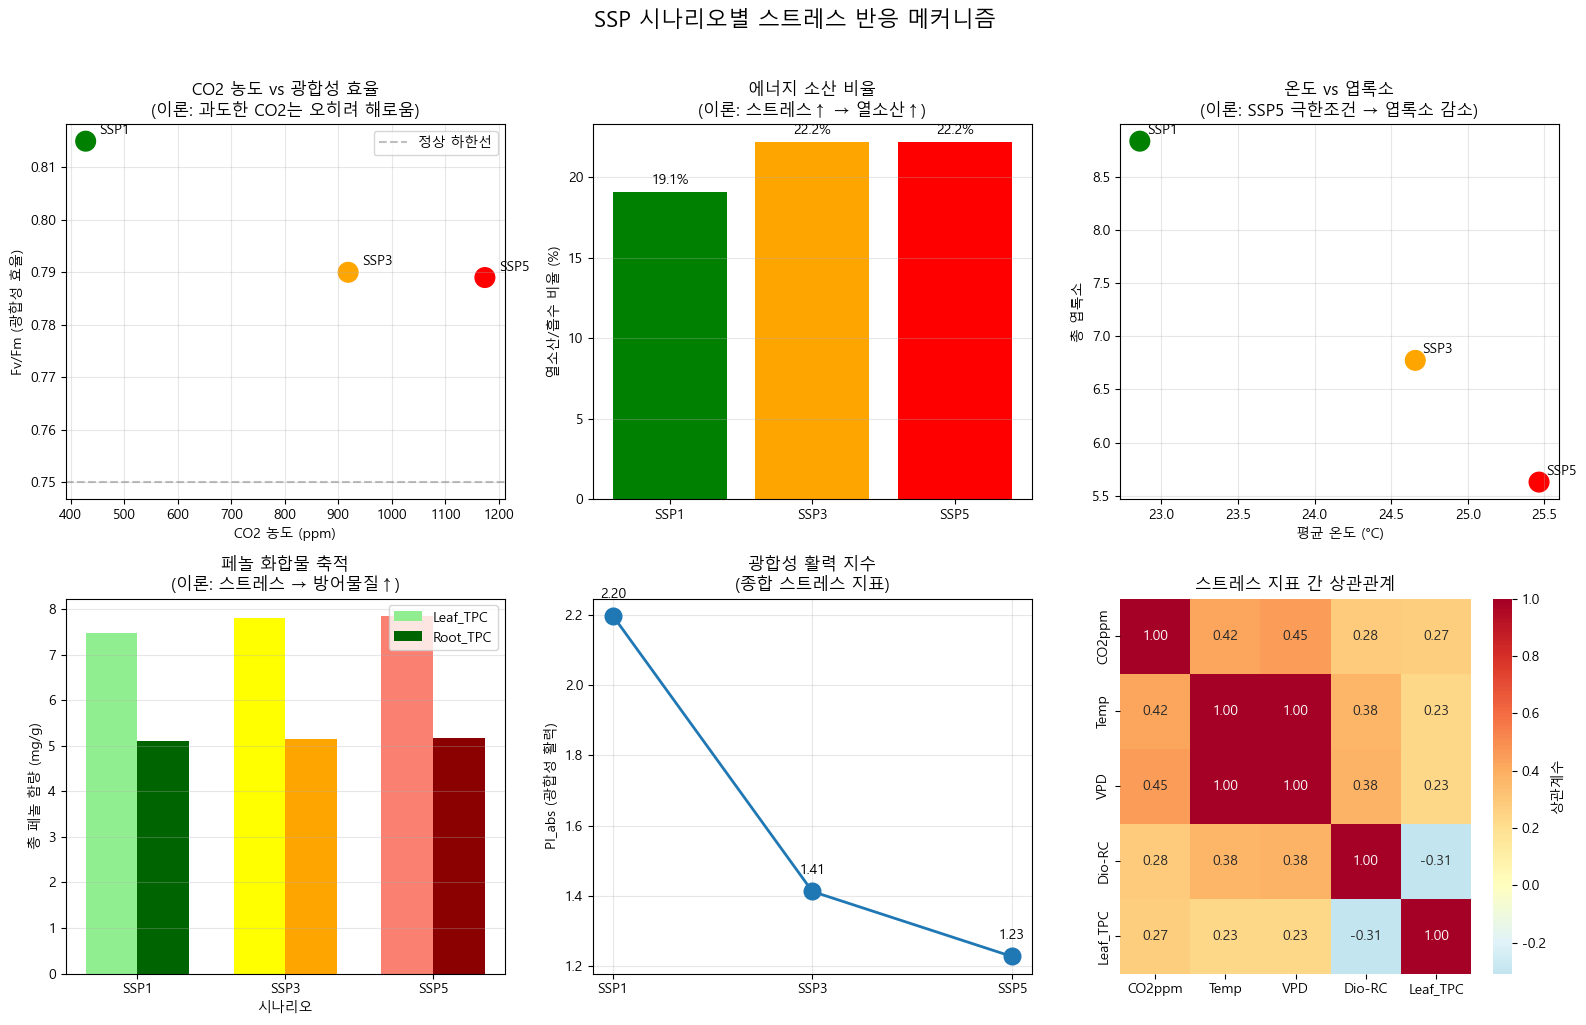

In [14]:
# 시각화: SSP 시나리오 비교
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('SSP 시나리오별 스트레스 반응 메커니즘', fontsize=16, y=1.02)

scenarios = ['SSP1', 'SSP3', 'SSP5']
colors_ssp = {'SSP1': 'green', 'SSP3': 'orange', 'SSP5': 'red'}

# 1. CO2 농도 vs 광합성 효율
ax1 = axes[0, 0]
co2_values = [scenario_stats.loc[s, 'CO2ppm'] for s in scenarios]
fv_fm_values = [scenario_stats.loc[s, 'Fv-Fm'] for s in scenarios]
ax1.scatter(co2_values, fv_fm_values, s=200, c=[colors_ssp[s] for s in scenarios])
for i, s in enumerate(scenarios):
    ax1.annotate(s, (co2_values[i], fv_fm_values[i]), 
                xytext=(10, 5), textcoords='offset points')
ax1.set_xlabel('CO2 농도 (ppm)')
ax1.set_ylabel('Fv/Fm (광합성 효율)')
ax1.set_title('CO2 농도 vs 광합성 효율\n(이론: 과도한 CO2는 오히려 해로움)')
ax1.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5, label='정상 하한선')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. 열소산 비율
ax2 = axes[0, 1]
dissipation = [scenario_stats.loc[s, 'Dissipation_Ratio'] for s in scenarios]
bars = ax2.bar(scenarios, dissipation, color=[colors_ssp[s] for s in scenarios])
ax2.set_ylabel('열소산/흡수 비율 (%)')
ax2.set_title('에너지 소산 비율\n(이론: 스트레스↑ → 열소산↑)')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, dissipation):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.5,
            f'{val:.1f}%', ha='center')

# 3. 엽록소 vs 스트레스
ax3 = axes[0, 2]
tchl_values = [scenario_stats.loc[s, 'TChl'] for s in scenarios]
temp_values = [scenario_stats.loc[s, 'Temp'] for s in scenarios]
scatter = ax3.scatter(temp_values, tchl_values, s=200,
                     c=[colors_ssp[s] for s in scenarios])
for i, s in enumerate(scenarios):
    ax3.annotate(s, (temp_values[i], tchl_values[i]),
                xytext=(5, 5), textcoords='offset points')
ax3.set_xlabel('평균 온도 (°C)')
ax3.set_ylabel('총 엽록소')
ax3.set_title('온도 vs 엽록소\n(이론: SSP5 극한조건 → 엽록소 감소)')
ax3.grid(True, alpha=0.3)

# 4. 페놀 화합물 반응
ax4 = axes[1, 0]
leaf_tpc = [scenario_stats.loc[s, 'Leaf_TPC'] for s in scenarios]
root_tpc = [scenario_stats.loc[s, 'Root_TPC'] for s in scenarios]
x = np.arange(len(scenarios))
width = 0.35
bars1 = ax4.bar(x - width/2, leaf_tpc, width, label='Leaf_TPC',
               color=['lightgreen', 'yellow', 'salmon'])
bars2 = ax4.bar(x + width/2, root_tpc, width, label='Root_TPC',
               color=['darkgreen', 'orange', 'darkred'])
ax4.set_xlabel('시나리오')
ax4.set_ylabel('총 페놀 함량 (mg/g)')
ax4.set_title('페놀 화합물 축적\n(이론: 스트레스 → 방어물질↑)')
ax4.set_xticks(x)
ax4.set_xticklabels(scenarios)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. PI_abs 변화
ax5 = axes[1, 1]
pi_values = [scenario_stats.loc[s, 'PI_abs'] for s in scenarios]
ax5.plot(scenarios, pi_values, marker='o', markersize=12, linewidth=2)
ax5.set_ylabel('PI_abs (광합성 활력)')
ax5.set_title('광합성 활력 지수\n(종합 스트레스 지표)')
ax5.grid(True, alpha=0.3)
for i, val in enumerate(pi_values):
    ax5.text(i, val + 0.05, f'{val:.2f}', ha='center')

# 6. 스트레스 지표 상관 매트릭스
ax6 = axes[1, 2]
stress_indicators = df_merged[['CO2ppm', 'Temp', 'VPD', 'Dio-RC', 'Leaf_TPC']].corr()
sns.heatmap(stress_indicators, annot=True, fmt='.2f', cmap='RdYlBu_r',
           center=0, ax=ax6, cbar_kws={'label': '상관계수'})
ax6.set_title('스트레스 지표 간 상관관계')

plt.tight_layout()
plt.show()

- SSP3, 5 과한 CO2로 인해 스트레스 지수 매우 높아짐.
- 특정 온도 이상 시 열 민감한 식물인 것 확인 가능(3번째 그래프)
- 스트레스 반응 -> 방어 반응 높아짐
- 엽록소 감소하는 반응도 온도, CO2 등 상승했을 때 천궁의 생존 전략
- 광합성 활력 지수 급격 감소를 통해 열 스트레스 영향이 큼
- VPD = Clausius-Clapeyron 방정식인 온도 포화수증기압의 관계로 인해 온도와 VPD가 상관관계가 높게 보임.
- 물리학 법칙 필연적 결과(당연한 것으로 파악해야함.)

### VPD 스트레스와 방어 메커니즘
- VPD 정상, 스트레스 구간 생리 지표
- 고온기 정상기 비교
- 열소산 페놀 생산 관계

In [15]:
# VPD 스트레스 분석
df_merged['vpd_stress'] = df_merged['VPD'] > 2.5
df_merged['temp_stress'] = df_merged['Temp'] > 25

In [16]:
# VPD 스트레스별 통계
vpd_analysis = df_merged.groupby('vpd_stress').agg({
    'VPD': 'mean',
    'Fv-Fm': 'mean',
    'Dio-RC': 'mean',
    'Leaf_TPC': 'mean',
    'Leaf_TFC': 'mean',
    'PI_abs': 'mean'
}).round(3)

In [17]:
print(vpd_analysis)

              VPD  Fv-Fm  Dio-RC  Leaf_TPC  Leaf_TFC  PI_abs
vpd_stress                                                  
False       2.179  0.804   0.408     7.560     4.979   1.860
True        2.656  0.788   0.542     7.947     4.172   1.215
